# Notes to self

  * The NR low dataset, bins 1 and 2, somehow did not work out. Recompute?
  * er low syst fails.

# Imports

In [1]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

Reading XAMS data from pickles...
Read data in 171.81 seconds


In [2]:
import pandas as pd
from tqdm import tqdm

In [22]:
#data_dir = '/data/xenon/ehogenbi/pulsefit/processing_pickles'
data_dir = '/home/erik/win/BCK/pulsefit_pickles_180114/'

# Functions

## Reading

In [4]:
import re

In [5]:
def read_pickles(dirname, base_name, max_i = None):
    if max_i is None:
        fns = os.listdir(dirname)
        fns = [os.path.join(dirname, fn) for fn in fns if re.match(base_name + '_....pickle', fn)]#if base_name in fn]
        fns = np.sort(fns)
    else:
        fns = [os.path.join(dirname, base_name + '_%03d.pickle' % i) for i in range(max_i)]
    if len(fns) == 0:
        print('Found no filenames for base %s, skipping...' % base_name)
        return pd.DataFrame([])
    dicts = []
    for fn in fns:
        with open(fn, 'rb') as f:
            current_dict = pickle.load(f)
            dicts.append(current_dict)
            if 'chi2' not in current_dict[0].keys():
                print('Warning: found no chi2 in file %s' % fn)
    dicts =  np.concatenate(dicts)
    
    df = pd.DataFrame(list(dicts))
    if df.isnull().values.any():
        print('Warning: found some NaNs or Nones in the dataframe. Maybe check your computation results?')
    if 'chi2' not in df.keys():
        print('Warning: found no chi2 for %s. Are you reading unprocessed files?' % (base_name))
    print('Read %d datapoints from %d files.' % (len(df), len(fns)))
    if 'stored_stat' in df.keys():
        # Brainfart when I put this in
        df['stored_stat_value'] = df['stored_stat']
        df['stored_stat'] = True
    return df



In [6]:
def round_df(df, decimals = 3):
    '''Round all non-str values of the dataframe to string ones.'''
    for key in df.keys():
        if type(df[key].iloc[0]) == str:
            continue
        df[key] = np.round(df[key], decimals)
    return df

def remove_common(df1, df2, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Remove all the elements in df1 that are already in df2 (comparing the keys in key_list)
    '''
    df1_sub = deepcopy(df1[key_list])
    df2_sub = deepcopy(df2[key_list])
    df1_sub = round_df(df1_sub)
    df2_sub = round_df(df2_sub)
    mask = np.invert(pd.concat([df1_sub,df2_sub]).duplicated(keep=False).values[:len(df1_sub)])
    print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df1)))
    df1 = df1[mask]
    df1 = df1.reset_index(drop=True)
    return df1

In [7]:
def read_and_combine(dirname, list_of_base, remove_duplicates = True, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Read dataframes with different base_name, merge dataframes and remove duplicates.
    '''
    df_list = []
    for base_name in list_of_base:
        df_list.append(read_pickles(dirname, base_name))
    df = pd.concat(df_list)
    df_keys = deepcopy(df[key_list])
    df_keys = round_df(df_keys)
    mask = np.invert(df_keys.duplicated().values)
    if sum(np.invert(mask)) > 0:
        print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df)))
    # Reset the index after concatenating
    df = df.reset_index(drop=True)
    return df

In [8]:
def read_energy_bins(data_dir, base_name, e_bins):
    '''
    Read all datasets.
    Returns list of dataframes
    '''
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_pickles(data_dir, base_name + '_%02d_%02d' % (e_min, e_max))
        ddf.append(df)
    return ddf

In [9]:
def read_and_combine_energy_bins(data_dir, base_names, e_bins):
    ddf = []
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_and_combine(data_dir, [base_name + '_%02d_%02d' % (e_min, e_max) for base_name in base_names])
        ddf.append(df)
    return ddf

## Plotting

In [10]:
def parslice_2d(df, x, y, key = 'chi2', plot_min = True, vmax=None, noshow=False, **kwargs):
    '''
    Plot the minimum values of chi2 for two variables (i.e. a projection of the minimum onto the 2d slice)
    '''
    dfmin = df.sort_values(by=key).iloc[0]
    if vmax is None:
        vmax = dfmin['chi2'] * 1.5
    grouped = df.groupby(by = (x, y)).min()
    grouped[x] = grouped.index.get_level_values(x)
    grouped[y] = grouped.index.get_level_values(y)
    plt.scatter(grouped[x], grouped[y], c= grouped[key], vmax = vmax, **kwargs)
    plt.colorbar(label='chi2/ndf')
    if plot_min:
        plt.scatter(dfmin[x], dfmin[y], color='red', marker='+', s = 500)

    plt.xlabel(x)
    plt.ylabel(y)
    if not noshow:
        plt.show()

In [11]:
def plot_all_slices(df, vmax = None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    if vmax is None:
        vmax = np.min(df[key] * 1.5 )
    for x, y in zip(['t3', 't1', 't1'], ['fs', 'tts', 't3']):
        parslice_2d(df, x, y,key=key, vmax = vmax,  **kwargs)
    return

In [12]:
def plot_slice_containing_point(df, x, y, row, **kwargs):
    df_sel = deepcopy(df)
    for key in row.keys():
        if (key == x) or (key == y) or (key=='chi2'):
            continue
        df_sel = df_sel[df_sel[key] == row[key]]
    plt.scatter(df_sel[x], df_sel[y], c= df_sel['chi2'], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

## Minimum stability

In [13]:
def get_some_minima(df, n_values=None, threshold=None, key='chi2'):
    '''
    Get the minimum n points of the dataframe up to chi2 value specified by threshold.
    If threshold is None, just take n values.
    If n_values is None, no restriction on the number of points.
    This function may be used to get the statistical error, although perhaps tricky how.
    Maximum deviation? std? 
    '''
    if n_values is None:
        selected_minima = df.sort_values(by = key)
    else:
        selected_minima = df.sort_values(by = key)[:n_values]
    if threshold is not None:
        selected_minima = selected_minima[selected_minima[key] <= threshold]
    print('Selected %d values with %s ranging from %.2f to %.2f...' % (len(selected_minima), 
                                                                       key,
                                                                         selected_minima[key].min(),
                                                                        selected_minima[key].max()))
    return deepcopy(selected_minima)

In [14]:
def scan_settings_and_get_min(x, df):
    '''
    x is a list of settings dicts, which may be produced by produce_settings_dict
    '''
    result = []
    for settings in tqdm(x):
        chi2 = recompute_chi2(df, **settings)
        minval = df.iloc[np.argmin(chi2)]
        minval = deepcopy(minval) # to shut up pandas
        minval = strip_junk(minval)
        minval['chi2'] = np.min(chi2)
        minval = merge_two_dicts(minval, settings)
        result.append(minval)
    return pd.DataFrame(result)

In [15]:
def check_minima(df, n_values, check_times):
    '''
    Take n minimum values, recompute them, take the mean and see if the minimum is still the minimum.
    '''
    electa = get_some_minima(df, n_values)
    electa['ranking_before'] = range(len(electa))
    chi2_new = []
    for index, settings in electa.iterrows():
        print('Working on setting %d' % index)
        settings = deepcopy(dict(settings))
        settings = strip_junk(settings)
        gofs = [gof(**settings) for _ in range(check_times)]
        chi2_new.append(np.average(gofs))
    electa['chi2_new_%d_times' % check_times] = chi2_new
    electa = electa.sort_values(by = 'chi2_new_%d_times' % check_times)
    electa['ranking_after'] = range(len(electa))
    electa = electa.sort_values(by='chi2')
    changed = electa['ranking_before'] != electa['ranking_after']
    if sum(changed) != 0:
        print('Warning: I detected a changing order!')
    return electa


In [16]:
def print_minima(mins):
    print('Giving the standard deviation for %d points...' % len(mins))
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f +- %.3f" % (key, np.average(mins[key]), np.std(mins[key])))
    print('Giving the MAXIMUM deviation from BEST-FIT POINT (using chi2) for %d points...' % len(mins))
    bestfit = mins.sort_values(by='chi2').iloc[0]
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f + %.3f - %.3f" % (key, bestfit[key],
                                            bestfit[key] - np.min(mins[key]),
                                            np.max(mins[key]) - bestfit[key]
                                           ))
    return

In [17]:
def recompute_chi2(df, **p):
    '''
    Recompute chi2 with new settings given in p.
    Parameters will be passed to `gof_manual`.
    '''
    chi2_new = []
    for i, row in df.iterrows():
        p2 = merge_two_dicts(dict(row), p)
        chi2_new.append(gof_manual(verbose=False, **p2))
    return np.array(chi2_new)

In [18]:
def minvalue(df, key='chi2', to_input = False, keep_only_stored = False):
    '''
    Take the value where minimum occurs
    '''
    minrow = df.iloc[df[key].argmin()]
    minrow = dict(minrow)
    if to_input:
        # Prepare to input into recomputing
        return minrow
    else:
        if not keep_only_stored:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray)}
        else:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray or k is 'stored_stat_value')}
        return minrow

In [19]:
def build_fine_grid(df, n_values_min, keys, current_step_size, increase_factor = 2, 
                    keys_to_copy = ['dset', 'e_min', 'e_max', 'n_photons']):
    mins = get_some_minima(df, n_values = n_values_min)
    all_points = []
    for _, minval in mins.iterrows():
        neighbours = produce_settings_dicts(keys, 
                               [minval[key] - current_step_size[i] for i, key in enumerate(keys)],
                               [minval[key] + current_step_size[i] for i, key in enumerate(keys)],
                               [1/increase_factor * current_step_size[i] for i in range(len(current_step_size))],
                                verbose=False
                              )
        all_points.append(neighbours)
    all_points = np.concatenate(all_points)
    all_points = [{k : np.round(v, 5) for k, v in points.items()} for points in all_points]
    all_unique_points = [dict(t) for t in set([tuple(d.items()) for d in all_points])]
    print('Removed %d of %d settings that were nonunique, %d left...' % (len(all_points) - len(all_unique_points),
                                                                         len(all_points), len(all_unique_points)))
    good_points = [d for d in all_unique_points if ((d['t1'] > 1e-3) and (d['tts'] > 1e-3))]
    print('Also removed %d points with zero t1 or tts, %d left!' % (len(all_unique_points) - len(good_points),
                                                                    len(good_points)))
    const_key_values = {key : df[key].iloc[0] for key in keys_to_copy}
    for i in range(len(good_points)):
        for key in keys_to_copy:
            good_points[i][key] = const_key_values[key]

    
    return good_points

In [20]:
def strip_junk(dic):
    dic['stored_stat_value'] = dic['stored_stat']
    dic = {k : v for k, v in dic.items() if (type(v) is not np.ndarray) or k == 'stored_stat_value' }
    return dic

## Placeholder

In [21]:
print('Done!')

Done!


In [ ]:
# Run all above from this cell

# Reading results

### Statistical errors, fine grid production

In [250]:
mins = get_some_minima(df, 20)
print_minima(mins)

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Giving the standard deviation for 20 points...
fs = 0.237 +- 0.010
t3 = 21.700 +- 0.458
t1 = 1.625 +- 0.444
tts = 1.512 +- 0.185


In [251]:
fine = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.0125, 0.5, 0.5, 0.25])

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Removed 6699 of 12500 settings that were nonunique, 5801 left...
Also removed 0 points with zero t1 or tts, 5801 left!


In [252]:
df_fine = pd.DataFrame(fine)

In [253]:
np.diff(np.unique(df['fs']))

array([ 0.0125,  0.0125,  0.0125,  0.0125])

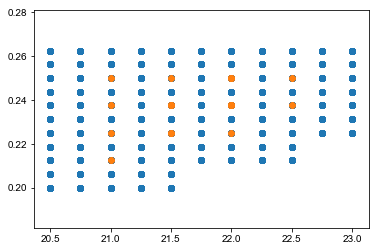

In [254]:
plt.scatter(df_fine['t3'], df_fine['fs'])
plt.scatter(mins['t3'], mins['fs'])
plt.show()

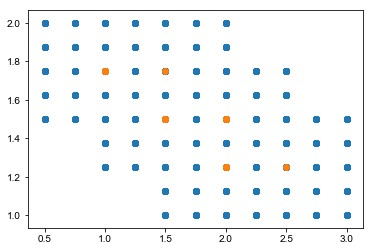

In [255]:
plt.scatter(df_fine['t1'], df_fine['tts'])
plt.scatter(mins['t1'], mins['tts'])
plt.show()

In [256]:
pickle.dump(fine, open('/data/xenon/ehogenbi/pulsefit/pickles/nr_finegrid.pickle', 'wb'))

### Systematic uncertainties

In [257]:
syst_settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], [-16, 100, 0], [-4, 150, 2e-4], [4, 10, 1e-4], 
                                   block_size = np.inf)

Loaded 72 settings.


In [258]:
mins = scan_settings_and_get_min(syst_settings, df)

100%|██████████| 72/72 [01:22<00:00,  1.09s/it]


In [259]:
print_minima(mins)

Giving the standard deviation for 72 points...
fs = 0.235 +- 0.010
t3 = 21.549 +- 0.207
t1 = 1.583 +- 0.400
tts = 1.458 +- 0.200


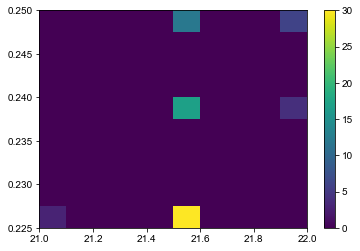

In [260]:
plt.hist2d(mins['t3'], mins['fs'])
plt.colorbar()
plt.show()

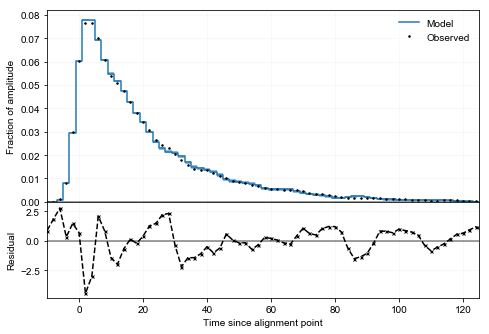

chi2 = 1.505357


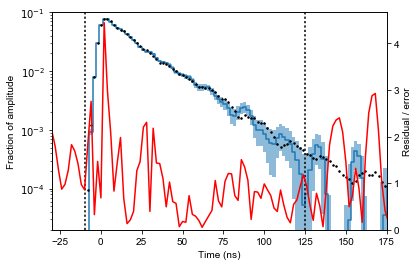

In [22]:
p = minvalue(df, key='chi2', to_input=True)
plot_model(verbose = False, **p)

In [25]:
minvalue(df)

{'chi2': 1.5359936092275124,
 'dset': 'nr',
 'fs': 0.23749999999999999,
 't1': 1.5,
 't3': 21.5,
 'tts': 1.5}

## ER energy scan

In [71]:
e_bins_er = [2, 5, 10, 20, 30, 50, 70]
ddf_er = read_and_combine_energy_bins(data_dir, ['er', 'er_f'], e_bins_er)

Read 6237 datapoints from 12 files.
Read 3953 datapoints from 13 files.
Read 6237 datapoints from 12 files.
Read 4592 datapoints from 15 files.
Read 5103 datapoints from 10 files.
Read 3961 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 4063 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 3877 datapoints from 12 files.
Read 5103 datapoints from 10 files.
Read 3952 datapoints from 13 files.


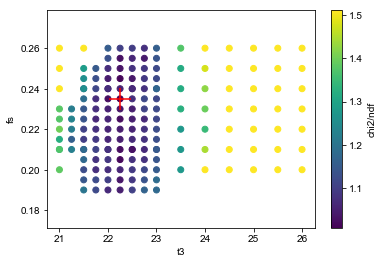

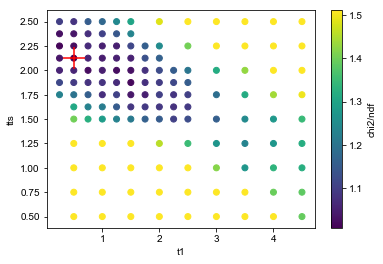

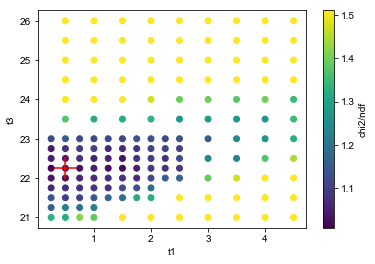

In [24]:
plot_all_slices(ddf_er[0])

In [26]:
minvalue(ddf_er[0])

{'chi2': 1.0076220581572282,
 'dset': 'er',
 'e_max': 5,
 'e_min': 2,
 'fs': 0.23499999999999999,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 0.5,
 't3': 22.25,
 'tts': 2.125}

## NR energy scan

In [45]:
e_bins_nr = [2, 5, 10, 15]

In [46]:
ddf = read_and_combine_energy_bins(data_dir, ['nr', 'nr_f'], e_bins_nr)

Read 6534 datapoints from 13 files.
Found no filenames for base nr_f_02_05, skipping...
Read 6534 datapoints from 13 files.
Found no filenames for base nr_f_05_10, skipping...
Read 6534 datapoints from 13 files.
Read 4054 datapoints from 13 files.


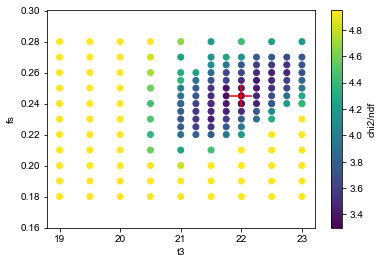

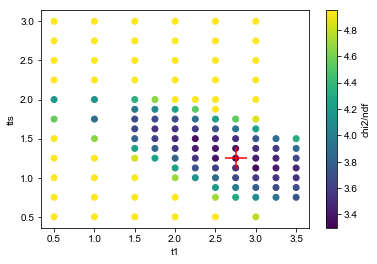

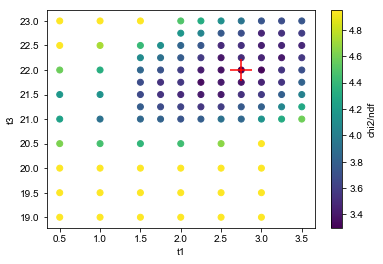

In [46]:
plot_all_slices(ddf_nr[2])

## ER low

In [22]:
ddf_er_l = read_and_combine_energy_bins(data_dir, ['er_l', 'er_l2', 'er_l_f'], [2, 5, 10, 20, 30, 50, 70])

Read 9801 datapoints from 9 files.
Found no filenames for base er_l2_02_05, skipping...
Read 4367 datapoints from 14 files.
Read 7290 datapoints from 7 files.
Read 2916 datapoints from 2 files.
Read 4575 datapoints from 15 files.
Read 5103 datapoints from 5 files.
Read 13068 datapoints from 13 files.
Read 4464 datapoints from 14 files.
Removing 3645 of 22635 items, already exist...
Read 6237 datapoints from 6 files.
Read 25200 datapoints from 25 files.
Read 4522 datapoints from 15 files.
Removing 3564 of 35959 items, already exist...
Read 5400 datapoints from 5 files.
Read 25740 datapoints from 25 files.
Read 4256 datapoints from 14 files.
Removing 1890 of 35396 items, already exist...
Read 5103 datapoints from 5 files.
Read 11880 datapoints from 11 files.
Read 3218 datapoints from 10 files.
Removing 675 of 20201 items, already exist...


In [37]:
df = ddf_er_l[5]

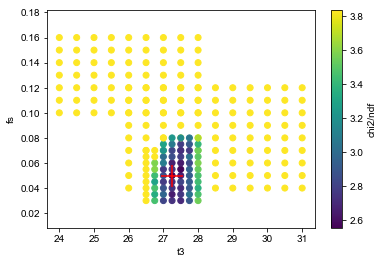

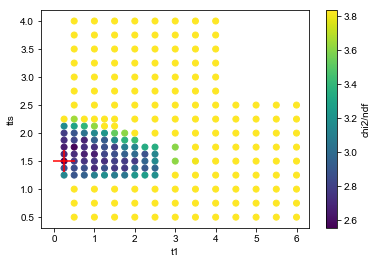

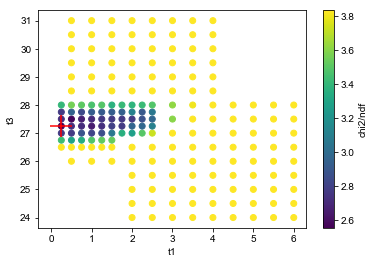

In [38]:
plot_all_slices(df)

In [39]:
minvalue(df)

{'chi2': 2.556434539617451,
 'dset': 'er_l',
 'e_max': 70,
 'e_min': 50,
 'fs': 0.050000000000000003,
 'n_photons': 2000000,
 'stored_stat': True,
 't1': 0.25,
 't3': 27.25,
 'tts': 1.5}

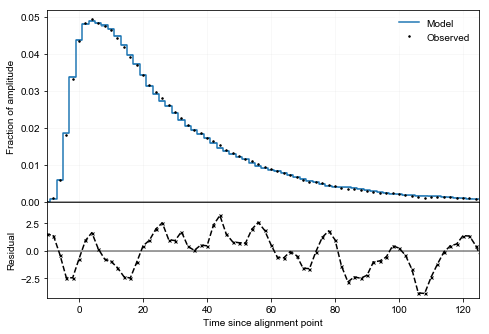

chi2 = 2.556435


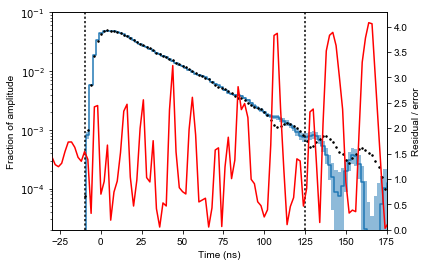

In [40]:
plot_model_manual(**minvalue(df, to_input=True))

## NR low

In [365]:
# for df in ddf_nr_l:
#     parslice_2d(df, 't3', 't1')

In [62]:
e_bins_nr = [2, 5, 10, 15]
ddf_nr_l = read_and_combine_energy_bins(data_dir, ['nr_l', 
                                                   # 'nr_l2',
                                                   'nr_l3', 
                                                   'nr_l_f'], e_bins_nr)
#ddf_nr_l = read_energy_bins(data_dir, 'nr_l', e_bins_nr)

Read 6534 datapoints from 13 files.
Read 15730 datapoints from 62 files.
Read 4720 datapoints from 15 files.
Removing 4185 of 26984 items, already exist...
Read 6534 datapoints from 13 files.
Read 15730 datapoints from 62 files.
Read 4445 datapoints from 14 files.
Removing 4179 of 26709 items, already exist...
Read 6534 datapoints from 13 files.
Read 15730 datapoints from 62 files.
Read 4306 datapoints from 14 files.
Removing 4167 of 26570 items, already exist...


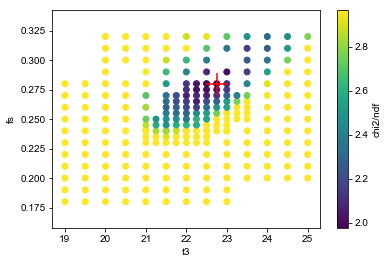

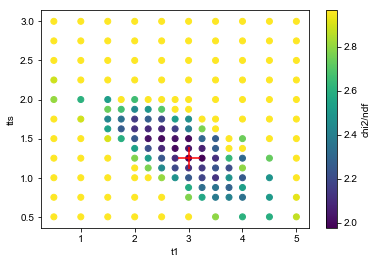

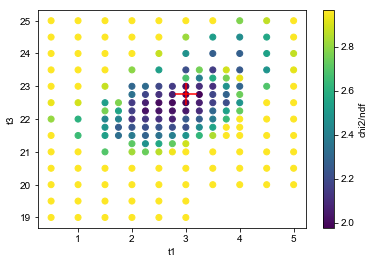

In [67]:
plot_all_slices(ddf_nr_l[1])

In [ ]:
# xs = [produce_settings_dicts(['t3', 'fs',  't1', 'tts'], lower_bound, upper_bound, step_size, 1000000, **p)
#         for (lower_bound, upper_bound, step_size, p) in zip(lower_bounds, upper_bounds, step_sizes, ps)]
# print('Produced a total of %d jobs for %d datasets.' % (np.sum([len(x) for x in xs]), len(xs)))
# ddf = read_energy_bins('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'nr_l', [2, 5, 10, 15])
# xs_new = []
# for x, df in zip(xs, ddf):
#     x = remove_common(pd.DataFrame(list(x)), df)
#     x = x.to_dict('records')
#     x = split_settings(x, 1000)
#     xs_new.append(xs)
# xs = xs_new

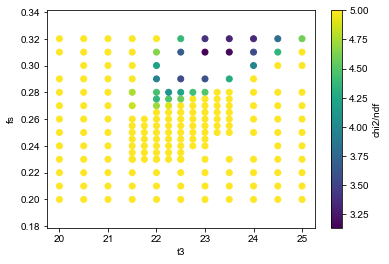

In [69]:
plot_slice_containing_point(ddf_nr_l[2], 't3', 'fs', minvalue(ddf_nr_l[2]), vmax = 5)

In [70]:
ddf = read_energy_bins('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'nr_l', [2, 5, 10, 15])

Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.


## NR investigation

In [88]:
d = xams_data['nr']

In [96]:
xams_data.keys()

dict_keys(['nr', 'nr_l', 'bg_nr', 'er_l', 'er', 'er_0'])

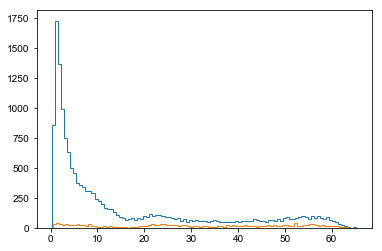

In [98]:
plt.hist(d['e_ces'], bins=100, histtype='step')
plt.hist(xams_data['bg_nr']['e_ces'], bins=100, histtype='step')
plt.show()

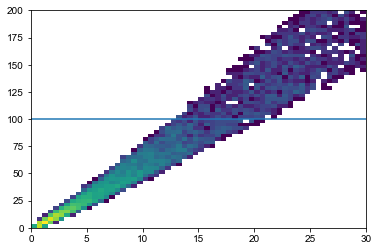

In [104]:
plt.hist2d(d['e_ces'], d['s1'], bins=60, norm=LogNorm(), range=((0, 30), (0, 200)))
plt.axhline(100)
plt.show()

Up to about 15 keVee is good.

In [112]:
p_nr = dict(n_photons = int(5e5), e_min = 10, e_max = 15, dset = 'nr', 
            # neglect_systematic = True, neglect_statistical = True,
            bootstrap_trials = 50,
            fs = 0.23, t3 = 22, t1 = 1.5, tts = 1.5
           )

{'t_min': -10.0, 'aft': 0.28, 'e_max': 15, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 10, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


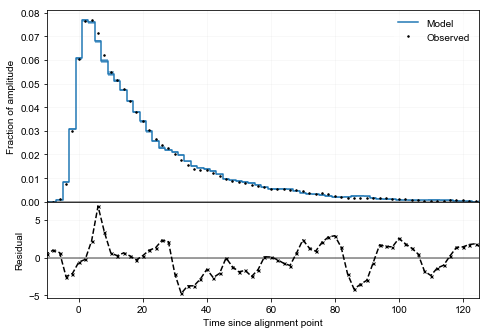

chi2 = 4.422413


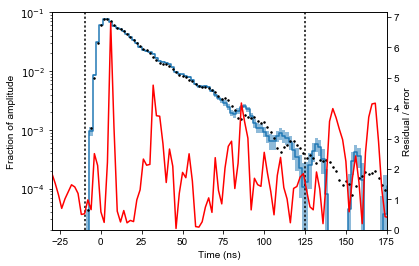

In [113]:
plot_model(**p_nr)

In [114]:
p_nr = dict(n_photons = int(5e5), e_min = 5, e_max = 10, dset = 'nr', 
            # neglect_systematic = True, neglect_statistical = True,
            bootstrap_trials = 50,
            fs = 0.23, t3 = 22, t1 = 1.5, tts = 1.5
           )

{'t_min': -10.0, 'aft': 0.28, 'e_max': 10, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 5, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


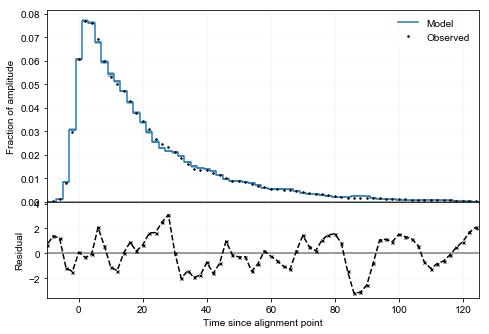

chi2 = 1.784474


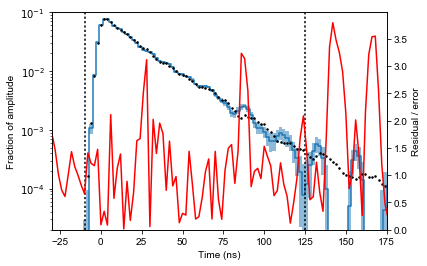

In [115]:
plot_model(**p_nr)

{'t_min': -10.0, 'aft': 0.28, 'e_max': 5, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 2, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


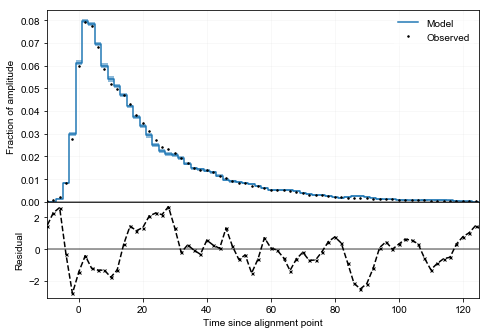

chi2 = 1.464754


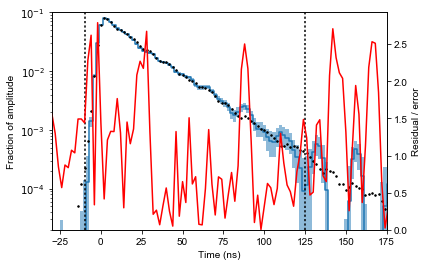

In [116]:
p_nr['e_min'] = 2
p_nr['e_max'] = 5
plot_model(**p_nr)

In [214]:
p = dict(
    # Dataset selection
    dset = 'er',
    e_min = 50,
    e_max = 70,
    
    # Speeding up computation
    neglect_systematic = True,
    neglect_statistical = False,
    bootstrap_trials = 10,
    
    # Fixed values
    t3 = 22.,
    t1 = 1.5,
    tts = 1.5,
    
    s1_model = 'recombination',
    fs = 0.1,
    tr = 200,
    f_r = 0.1,
    fs_r = 0.5,
)

In [215]:
# stored_stat_value = real_s1_wv_sigma(**p)

In [216]:
 p['stored_stat_value'] = stored_stat_value

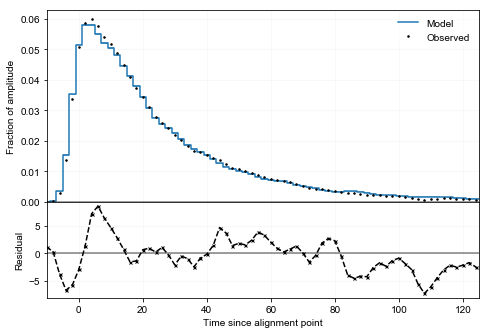

chi2 = 10.334201


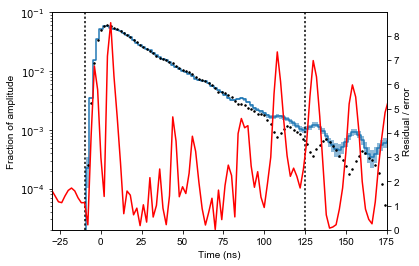

In [217]:
plot_model(verbose=False, **p)

# Process all four-fit data

### Functions

In [23]:
def min_per_e(ddf, dset, chi2_max = None, chi2_max_factor = None, mode='std'):
    '''
    Get the parameters where chi2 is minimal up to a certain chi2 value.
    This gives the statistical error
    '''
    d = xams_data[dset]
    x = []

    for i, df in enumerate(ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        if chi2_max is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max)
        elif chi2_max_factor is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max_factor) 
        else:
            raise ValueError('Configuration not understood.')
        for key in ['t3', 't1', 'fs', 'tts']:
            fit[key] = np.mean(mins[key])
            if mode == 'std':
                fit['d' + key] = np.std(mins[key])
            elif mode == 'extreme':
                fit['d' + key] = 0.5 * (np.max(mins[key]) - np.min(mins[key]))
        x.append(fit)
    x = pd.DataFrame(x)
    return x

In [24]:
def min_per_e_syst(ddf, dset, settings):
    '''
    Get the values of paramters where chi2 is minimal if parameters are varied. 
    '''
    all_mins = []
    for i, df in enumerate(ddf):
        mins = scan_settings_and_get_min(settings, df)
        print(mins)
        all_mins.append(mins)
        
    with open('pickle_dir/mins_per_e_%s.pickle' % dset, 'wb') as f:
        pickle.dump(all_mins, f)
    return all_mins

In [25]:
def process_mins(ddf, dset, mins_per_e = None):
    '''Requires a list of dataframes containing the minimum values.'''
    if mins_per_e is None:
        with open('pickle_dir/mins_per_e_%s.pickle' % dset, 'rb') as f:
            mins_per_e = pickle.load(f)
            print('Read %d settings in %d bins from file.' % (len(mins_per_e[0]), len(mins_per_e)))
    d = xams_data[dset]
    x = []
    for mins, df in zip(mins_per_e, ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        for key in ['t3', 't1', 'fs', 'tts', 'chi2']:
            fit[key] = np.mean(mins[key])
            fit['d' + key] = np.std(mins[key])
        x.append(fit)
    x = pd.DataFrame(x)
    return x

In [26]:
def process_and_combine_syst_and_stat(ddf, dset, chi2_max_factor, mode, verbose = False):
    x_stat = min_per_e(ddf, dset, chi2_max_factor = chi2_max_factor, mode=mode)
    x_syst = process_mins(ddf, dset) # assuming all from file
    # COMBINE ALL
    x = []
    for i in range(len(x_stat)):
        fit = {}
        for key in ['e', 'de', 'chi2', 'dchi2']:
            fit[key] = x_syst[key].values[i]
        minval = minvalue(ddf[i])
        for key in ['t3', 't1', 'fs', 'tts']:
            # For the minimum, just take the value that is the minimum
            fit[key] = minval[key]
            fit['d' + key + '_syst'] = x_syst['d' + key].values[i]
            fit['d' + key + '_stat'] = x_stat['d' + key].values[i]
            fit['d' + key] = np.sqrt(fit['d' + key + '_syst']**2 + fit['d' + key + '_syst']**2)
        x.append(fit)
    return pd.DataFrame(x)

### Read

In [27]:
# Energy bins
e_bins_er = [2, 5, 10, 20, 30, 50, 70]
e_bins_nr = [2, 5, 10, 15]

In [28]:
# Reading the dataframes
ddf_er = read_and_combine_energy_bins(data_dir, ['er', 'er_f'], e_bins_er)
ddf_er_l = read_and_combine_energy_bins(data_dir, ['er_l', 'er_l2', 'er_l_f'], e_bins_er)
ddf_nr = read_and_combine_energy_bins(data_dir, ['nr', 'nr_f'], e_bins_nr)
ddf_nr_l = read_and_combine_energy_bins(data_dir, ['nr_l',  # 'nr_l2'
                                                   'nr_l3', 'nr_l_f'], e_bins_nr)
print('Done')

Read 6237 datapoints from 12 files.
Read 3953 datapoints from 13 files.
Read 6237 datapoints from 12 files.
Read 4592 datapoints from 15 files.
Read 5103 datapoints from 10 files.
Read 3961 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 4063 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 3877 datapoints from 12 files.
Read 5103 datapoints from 10 files.
Read 3952 datapoints from 13 files.
Read 9801 datapoints from 9 files.
Found no filenames for base er_l2_02_05, skipping...
Read 4367 datapoints from 14 files.
Read 7290 datapoints from 7 files.
Read 2916 datapoints from 2 files.
Read 4575 datapoints from 15 files.
Read 5103 datapoints from 5 files.
Read 13068 datapoints from 13 files.
Read 4464 datapoints from 14 files.
Removing 3645 of 22635 items, already exist...
Read 6237 datapoints from 6 files.
Read 25200 datapoints from 25 files.
Read 4522 datapoints from 15 files.
Removing 3564 of 35959 items, already exist...
Read 5400 datapoints from 5 

In [ ]:
#  for f in  *_f[0-9]*; do mv "$f" "${f//_f/_f_}"; done

### Systematic errors

In [79]:
settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], 
                                  [-12, 110, 0], [-6, 140, 2e-4], [2, 5, 1e-4], block_size=100000)

Loaded 84 settings.


In [90]:
for ddf, dset in zip([ddf_er, ddf_er_l, ddf_nr, ddf_nr_l], ['er', 'er_l', 'nr', 'nr_l']):
    if dset in ['er', 'nr', 'nr_l']:
        print('Skipping dset %s ...' % dset)
        continue
    print('Now processing dset %s' % dset)
    systscan = min_per_e_syst(ddf, dset, settings)

  0%|          | 0/84 [00:00<?, ?it/s]

Skipping dset er ...
Now processing dset er_l


  0%|          | 0/84 [00:00<?, ?it/s]

        chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0   1.707160  er_l      5      2        0.0000  0.25     500000        True   
1   1.628254  er_l      5      2        0.0001  0.25     500000        True   
2   1.477071  er_l      5      2        0.0002  0.25     500000        True   
3   1.725764  er_l      5      2        0.0000  0.25     500000        True   
4   1.648835  er_l      5      2        0.0001  0.25     500000        True   
5   1.498416  er_l      5      2        0.0002  0.25     500000        True   
6   1.611657  er_l      5      2        0.0000  0.25     500000        True   
7   1.569510  er_l      5      2        0.0001  0.25     500000        True   
8   1.462694  er_l      5      2        0.0002  0.25     500000        True   
9   1.638453  er_l      5      2        0.0000  0.25     500000        True   
10  1.595754  er_l      5      2        0.0001  0.25     500000        True   
11  1.487379  er_l      5      2        0.0002  0.25

  0%|          | 0/84 [00:00<?, ?it/s]

        chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0   1.311174  er_l     10      5        0.0000  0.16     500000        True   
1   1.170103  er_l     10      5        0.0001  0.16     500000        True   
2   0.946637  er_l     10      5        0.0002  0.16     500000        True   
3   1.293280  er_l     10      5        0.0000  0.16     500000        True   
4   1.170687  er_l     10      5        0.0001  0.16     500000        True   
5   0.955059  er_l     10      5        0.0002  0.16     500000        True   
6   1.278403  er_l     10      5        0.0000  0.16     500000        True   
7   1.169640  er_l     10      5        0.0001  0.16     500000        True   
8   0.962153  er_l     10      5        0.0002  0.16     500000        True   
9   1.293625  er_l     10      5        0.0000  0.16     500000        True   
10  1.185222  er_l     10      5        0.0001  0.16     500000        True   
11  0.976431  er_l     10      5        0.0002  0.16

  0%|          | 0/84 [00:00<?, ?it/s]

        chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0   1.757987  er_l     20     10        0.0000  0.120    1000000        True   
1   1.382800  er_l     20     10        0.0001  0.120    1000000        True   
2   0.949401  er_l     20     10        0.0002  0.120    1000000        True   
3   1.684213  er_l     20     10        0.0000  0.120    1000000        True   
4   1.372277  er_l     20     10        0.0001  0.120    1000000        True   
5   0.954119  er_l     20     10        0.0002  0.120    1000000        True   
6   1.664876  er_l     20     10        0.0000  0.120    1000000        True   
7   1.376082  er_l     20     10        0.0001  0.120    1000000        True   
8   0.963296  er_l     20     10        0.0002  0.120    1000000        True   
9   1.637595  er_l     20     10        0.0000  0.120    1000000        True   
10  1.371172  er_l     20     10        0.0001  0.120    1000000        True   
11  0.968290  er_l     20     10        

  0%|          | 0/84 [00:00<?, ?it/s]

        chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0   2.148212  er_l     30     20        0.0000  0.085    1000000        True   
1   1.482446  er_l     30     20        0.0001  0.085    1000000        True   
2   0.875937  er_l     30     20        0.0002  0.085    1000000        True   
3   2.076259  er_l     30     20        0.0000  0.085    1000000        True   
4   1.481310  er_l     30     20        0.0001  0.085    1000000        True   
5   0.882658  er_l     30     20        0.0002  0.085    1000000        True   
6   2.033209  er_l     30     20        0.0000  0.085    1000000        True   
7   1.482871  er_l     30     20        0.0001  0.085    1000000        True   
8   0.890016  er_l     30     20        0.0002  0.085    1000000        True   
9   2.049642  er_l     30     20        0.0000  0.085    1000000        True   
10  1.501485  er_l     30     20        0.0001  0.095    1000000        True   
11  0.903470  er_l     30     20        

  0%|          | 0/84 [00:00<?, ?it/s]

        chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0   2.697031  er_l     50     30        0.0000  0.055    2000000        True   
1   1.656348  er_l     50     30        0.0001  0.055    2000000        True   
2   0.911386  er_l     50     30        0.0002  0.055    2000000        True   
3   2.584859  er_l     50     30        0.0000  0.055    2000000        True   
4   1.654832  er_l     50     30        0.0001  0.055    2000000        True   
5   0.918120  er_l     50     30        0.0002  0.055    2000000        True   
6   2.516075  er_l     50     30        0.0000  0.055    2000000        True   
7   1.656106  er_l     50     30        0.0001  0.055    2000000        True   
8   0.925535  er_l     50     30        0.0002  0.055    2000000        True   
9   2.559437  er_l     50     30        0.0000  0.055    2000000        True   
10  1.684653  er_l     50     30        0.0001  0.055    2000000        True   
11  0.941490  er_l     50     30        

100%|██████████| 84/84 [09:10<00:00,  6.54s/it]

        chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0   4.648024  er_l     70     50        0.0000  0.035    2000000        True   
1   2.686767  er_l     70     50        0.0001  0.050    2000000        True   
2   1.380563  er_l     70     50        0.0002  0.055    2000000        True   
3   4.530521  er_l     70     50        0.0000  0.035    2000000        True   
4   2.701241  er_l     70     50        0.0001  0.050    2000000        True   
5   1.395472  er_l     70     50        0.0002  0.055    2000000        True   
6   4.443123  er_l     70     50        0.0000  0.050    2000000        True   
7   2.706845  er_l     70     50        0.0001  0.050    2000000        True   
8   1.413546  er_l     70     50        0.0002  0.055    2000000        True   
9   4.415662  er_l     70     50        0.0000  0.050    2000000        True   
10  2.720414  er_l     70     50        0.0001  0.050    2000000        True   
11  1.435202  er_l     70     50        

### Combine all

In [29]:
chi2_max_factor = 1.016
chi2_mode = 'extreme'

In [30]:
x_er = process_and_combine_syst_and_stat(ddf_er, 'er', chi2_max_factor = chi2_max_factor, mode = chi2_mode)
x_er_l = process_and_combine_syst_and_stat(ddf_er_l, 'er_l', chi2_max_factor = chi2_max_factor, mode = chi2_mode)
x_nr = process_and_combine_syst_and_stat(ddf_nr, 'nr', chi2_max_factor = chi2_max_factor, mode = chi2_mode)
x_nr_l = process_and_combine_syst_and_stat(ddf_nr_l, 'nr_l', chi2_max_factor = chi2_max_factor, mode = chi2_mode)

Selected 3 values with chi2 ranging from 1.01 to 1.02...
Selected 2 values with chi2 ranging from 0.96 to 0.97...
Selected 1 values with chi2 ranging from 1.44 to 1.44...
Selected 1 values with chi2 ranging from 1.90 to 1.90...
Selected 4 values with chi2 ranging from 2.36 to 2.39...
Selected 9 values with chi2 ranging from 2.43 to 2.47...
Read 84 settings in 6 bins from file.
Selected 6 values with chi2 ranging from 1.48 to 1.50...
Selected 2 values with chi2 ranging from 1.14 to 1.15...
Selected 3 values with chi2 ranging from 1.31 to 1.32...
Selected 3 values with chi2 ranging from 1.44 to 1.45...
Selected 1 values with chi2 ranging from 1.67 to 1.67...
Selected 2 values with chi2 ranging from 2.56 to 2.58...
Read 84 settings in 6 bins from file.
Selected 3 values with chi2 ranging from 1.05 to 1.06...
Selected 4 values with chi2 ranging from 1.68 to 1.70...
Selected 2 values with chi2 ranging from 3.30 to 3.33...
Read 84 settings in 3 bins from file.
Selected 2 values with chi2 ran

In [31]:
# x_er = min_per_e(ddf_er, 'er', chi2_max_factor=chi2_max_factor)
# x_er_l = min_per_e(ddf_er_l, 'er_l', chi2_max_factor=chi2_max_factor)
# x_nr = min_per_e(ddf_nr, 'nr', chi2_max_factor=chi2_max_factor)
# x_nr_l = min_per_e(ddf_nr_l, 'nr_l', chi2_max_factor=chi2_max_factor)

## Mock data error and validation

### Check binning (should move / remove)

In [29]:
df = ddf_nr[1]

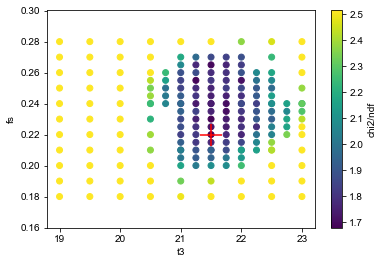

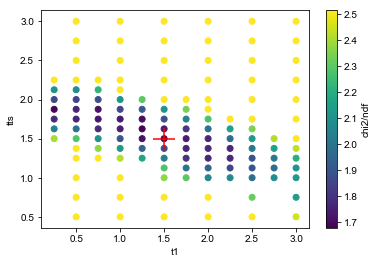

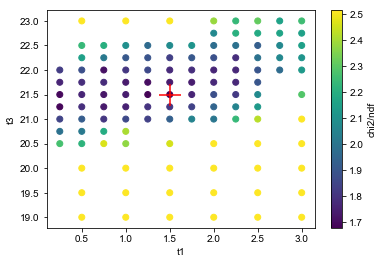

In [30]:
plot_all_slices(df)

### Functions

Now we go and generate the mock data. First take the minimum value, these will be the MC seeds.

In [64]:
from time import sleep
def generate_mock_and_refit(df, reps):
    '''
    Take the fit values from the dataframe df, simulate the waveforms using these values
    and then refit. This should quantify the statistical error on the procedure (can you call it that?)
    Repeat reps times.
    '''
    # Get one element for the print statements
    el = df.iloc[0]
    print('Dataset %s, %d to %d keV' % (el['dset'], el['e_min'], el['e_max']))
    minval = minvalue(df)
    del minval['n_photons']
    del minval['chi2']
    print('Here is the minimum:', minval)
    indices = []
    # Sleep for one second 
    sleep(1)
    # Generate the stat. error only once; this is time-consuming and the same for all mock data.
    mock_avg, mock_stored_stat = build_mock_data(verbose = False, return_stored=True, **minval)

    for i in tqdm(range(reps)):
        mock_avg = build_mock_data(verbose = False, return_stored=False, **minval)
        chi2s = []
        for index, row in df.iterrows():
            # Loop over all parameter points in the dataframe and get the chi2 value
            model, syst_err, spe_err = (row['model'], row['syst_err'], row['spe_err'])
            chi2 = gof_manual(mock_avg, model, syst_err, spe_err, stored_stat_value = mock_stored_stat, verbose=False)
            chi2s.append(chi2)
        # This list contains the index where the max values occur for all repetitions
        indices.append(np.argmin(chi2s))
    # This dict will hold summary values for all reps, mostly sigma
    err_dict = {}
    newfits = df.ix[indices]
    variables = ['t3', 't1', 'fs', 'tts']
    for var in variables:
        # Median and mean
        err_dict[var + '_median'] = np.percentile(newfits[var].values, 50)
        err_dict[var + '_mean'] = np.mean(newfits[var].values)
        # Percentiles: useful for skewed distributions
        err_dict['d' + var + '+'] = np.percentile(newfits[var].values, 50 + (68/2)) - err_dict[var + '_median']
        err_dict['d' + var + '-'] = err_dict[var + '_median'] - np.percentile(newfits[var].values, 50 - (68/2))
        # Sigma: useful for narrow distributions (since percentile will give you 0 sigma if almost all in one bin)
        err_dict['d' + var ] = np.std(newfits[var].values)
        
    return newfits, err_dict

In [65]:
def read_mock_data(reps, dsets = 'all', verbose=True):
    '''Read the data produced earlier'''
    if dsets == 'all':
        dsets = ['er', 'nr', 'er_l', 'nr_l']
    if verbose:
        print('Giving you the error for these datasets: ', dsets)
        
    # These objects are: a list (containing, er, nr, etc) of datasets (i.e. 2-5 keV, 5-10, etc) and for each dataset
    # the errors in those iterations or the list of iterations themselves if you want to be fancier.
    # Yeah. I know.
    all_errs_list = []
    all_newfits_list = []
    for dset in dsets:
        all_errs, all_newfits = pickle.load(open('mock_%s_%d_reps.pickle' % (dset, reps), 'rb'))
        all_errs_list.append(all_errs)
        all_newfits_list.append(all_newfits)
        
    return all_errs_list, all_newfits_list

### Build mock data error

Here, build the error for all the data.

In [ ]:

reps = 100
for ddf, name in zip([ddf_er, ddf_nr, ddf_er_l, ddf_nr_l], ['er', 'nr', 'er_l', 'nr_l']):
    all_newfits = []
    all_errs = []
    for df in ddf:
        newfits, err_dict = generate_mock_and_refit(df, reps)
        all_newfits.append(newfits)
        all_errs.append(err_dict)
    pickle.dump((all_errs, all_newfits), open('mock_%s_%d_reps.pickle' % (name, reps), 'wb'))

Dataset er, 2 to 5 keV
Here is the minimum: {'stored_stat': True, 'fs': 0.23499999999999999, 'dset': 'er', 'e_min': 2, 'tts': 2.125, 'e_max': 5, 't3': 22.25, 't1': 0.5}


100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


Dataset er, 5 to 10 keV
Here is the minimum: {'stored_stat': True, 'fs': 0.17999999999999999, 'dset': 'er', 'e_min': 5, 'tts': 1.625, 'e_max': 10, 't3': 23.75, 't1': 1.75}


100%|██████████| 100/100 [03:55<00:00,  2.35s/it]


Dataset er, 10 to 20 keV
Here is the minimum: {'stored_stat': True, 'fs': 0.17999999999999999, 'dset': 'er', 'e_min': 10, 'tts': 1.5, 'e_max': 20, 't3': 25.0, 't1': 2.75}


100%|██████████| 100/100 [04:01<00:00,  2.46s/it]


Dataset er, 20 to 30 keV
Here is the minimum: {'stored_stat': True, 'fs': 0.17000000000000001, 'dset': 'er', 'e_min': 20, 'tts': 1.375, 'e_max': 30, 't3': 25.25, 't1': 3.75}


100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


Dataset er, 30 to 50 keV
Here is the minimum: {'stored_stat': True, 'fs': 0.14499999999999999, 'dset': 'er', 'e_min': 30, 'tts': 1.375, 'e_max': 50, 't3': 25.25, 't1': 4.0}


100%|██████████| 100/100 [06:17<00:00,  3.62s/it]


Dataset er, 50 to 70 keV
Here is the minimum: {'stored_stat': True, 'fs': 0.13500000000000001, 'dset': 'er', 'e_min': 50, 'tts': 1.25, 'e_max': 70, 't3': 25.5, 't1': 4.5}


100%|██████████| 100/100 [07:49<00:00,  5.62s/it]


Dataset nr, 2 to 5 keV
Here is the minimum: {'stored_stat': True, 'fs': 0.23000000000000001, 'dset': 'nr', 'e_min': 2, 'tts': 1.75, 'e_max': 5, 't3': 21.5, 't1': 0.5}


### Read result back

In [46]:
dsets = ['er', 'nr', 'er_l', 'nr_l']
dddf = [ddf_er, ddf_nr, ddf_er_l, ddf_nr_l]
all_errs_list, all_newfits_list = read_mock_data(reps=10)

Giving you the error for these datasets:  ['er', 'nr', 'er_l', 'nr_l']


### Inspection

In [48]:
dseti = 0
var = 't3'

print('Choosing dataset %s' % dsets[dseti])


Choosing dataset er


In [60]:
x_plot = range(len(dddf[dseti]))
y_feed = [minvalue(df)[var] for df in dddf[dseti]] # The value used for the mock datasets
y_med  = [err[var + '_median'] for err in all_errs_list[dseti]]
# y_mean = [err[var + '_mean'] for err in all_errs_list[dseti]]
dyplus = [err['d' + var + '+'] for err in all_errs_list[dseti]]
dymin  = [err['d' + var + '-'] for err in all_errs_list[dseti]]
dysig  = [err['d' + var] for err in all_errs_list[dseti]]

In [59]:
all_errs_list[0][0]

{'dfs': 0.01307669683062202,
 'dfs+': 0.010300000000000004,
 'dfs-': 0.013100000000000028,
 'dt1': 0.53619026473818043,
 'dt1+': 0.8899999999999999,
 'dt1-': 0.14000000000000001,
 'dt3': 0.48476798574163293,
 'dt3+': 0.64000000000000057,
 'dt3-': 0.39000000000000057,
 'dtts': 0.20000000000000001,
 'dtts+': 0.19499999999999984,
 'dtts-': 0.25,
 'fs_median': 0.2225,
 't1_median': 0.75,
 't3_median': 22.25,
 'tts_median': 2.0}

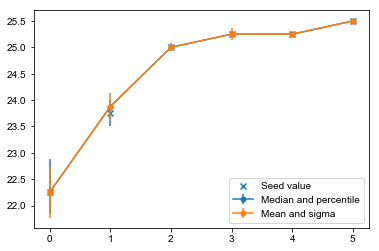

In [63]:
plt.scatter(x_plot, y_feed, label='Seed value', marker='x')
plt.errorbar(x_plot, y_med, (dymin, dyplus), marker='.', markersize = 10, label='Median and percentile')
plt.errorbar(x_plot, y_med, dysig, marker='.', markersize = 10, label='Mean and sigma')
plt.legend()

In [73]:
all_errs[-1]

{'dfs+': 0.0050000000000000044,
 'dfs-': 0.0050000000000000044,
 'dt1+': 0.25,
 'dt1-': 0.25,
 'dt3+': 0.25,
 'dt3-': 0.25,
 'dtts+': 0.0,
 'dtts-': 0.0,
 'fs_median': 0.245,
 't1_median': 2.75,
 't3_median': 22.0,
 'tts_median': 1.25}

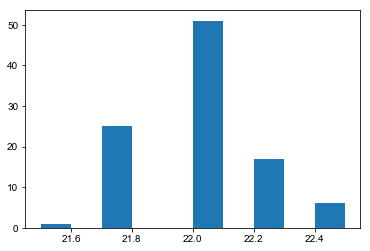

In [75]:
plt.hist(all_newfits[-1]['t3'])
plt.show()

In [70]:
np.std(all_newfits[-1]['t1'])

0.20461854754640402

## Fine grid production

In [32]:
grids = []
for ddf, dset in zip([ddf_nr_l], ['nr_l']):# zip([ddf_er, ddf_nr, ddf_er_l], ['er', 'nr', 'er_l']):
    for df in ddf:
        finegrid = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.01, 0.5, 0.5, 0.25])
        finegrid = pd.DataFrame(finegrid)
        finegrid = remove_common(finegrid, df)
        finegrid = finegrid.to_dict('records')
        grids.append(finegrid)
        # One element
        el = df.iloc[0]
        fn = '/data/xenon/ehogenbi/pulsefit/finegrid/%s_%02d_%02d_fine.pickle' % (el['dset'], el['e_min'], el['e_max'])
        print('Dumping to %s' % fn)
        with open(fn, 'wb') as f:
            pickle.dump(finegrid, f)

Selected 20 values with chi2 ranging from 1.19 to 1.25...
Removed 9509 of 12500 settings that were nonunique, 2991 left...
Also removed 0 points with zero t1 or tts, 2991 left!
Removing 2721 of 2991 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/nr_l_02_05_fine.pickle
Selected 20 values with chi2 ranging from 1.98 to 2.06...
Removed 9713 of 12500 settings that were nonunique, 2787 left...
Also removed 0 points with zero t1 or tts, 2787 left!
Removing 1235 of 2787 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/nr_l_05_10_fine.pickle
Selected 20 values with chi2 ranging from 3.13 to 3.50...
Removed 8439 of 12500 settings that were nonunique, 4061 left...
Also removed 0 points with zero t1 or tts, 4061 left!
Removing 417 of 4061 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/nr_l_10_15_fine.pickle


In [261]:
print('Total number of iterations: %d' % (len(np.concatenate(grids))))

Total number of iterations: 61595


In [263]:
grids

[[{'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.75,
   't3': 22.25,
   'tts': 2.375},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.0},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.125},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.25},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.375},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21,
   'n_photons': 500000,
   't1': 1.0,
   't3': 21.75,
   'tts': 1.625},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21,
   'n_photons': 500000,
   't1': 1.0,
   't3': 21.75,
   'tts': 1.75},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21

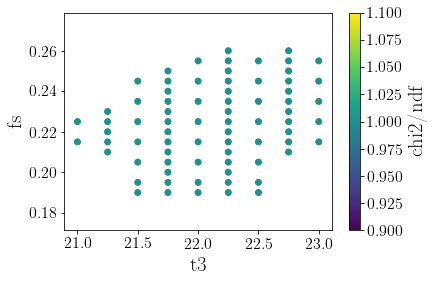

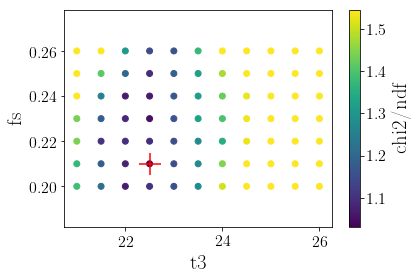

In [252]:
ding = pd.DataFrame(grids[0])
df = ddf_er[0]
ding['chi2'] = np.ones(len(ding))
plot_slice_containing_point(ding, 't3', 'fs', ding.iloc[20])
parslice_2d(df, 't3', 'fs')

# Pretty plots

## Eight panel plot

In [33]:
from matplotlib import gridspec

In [34]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


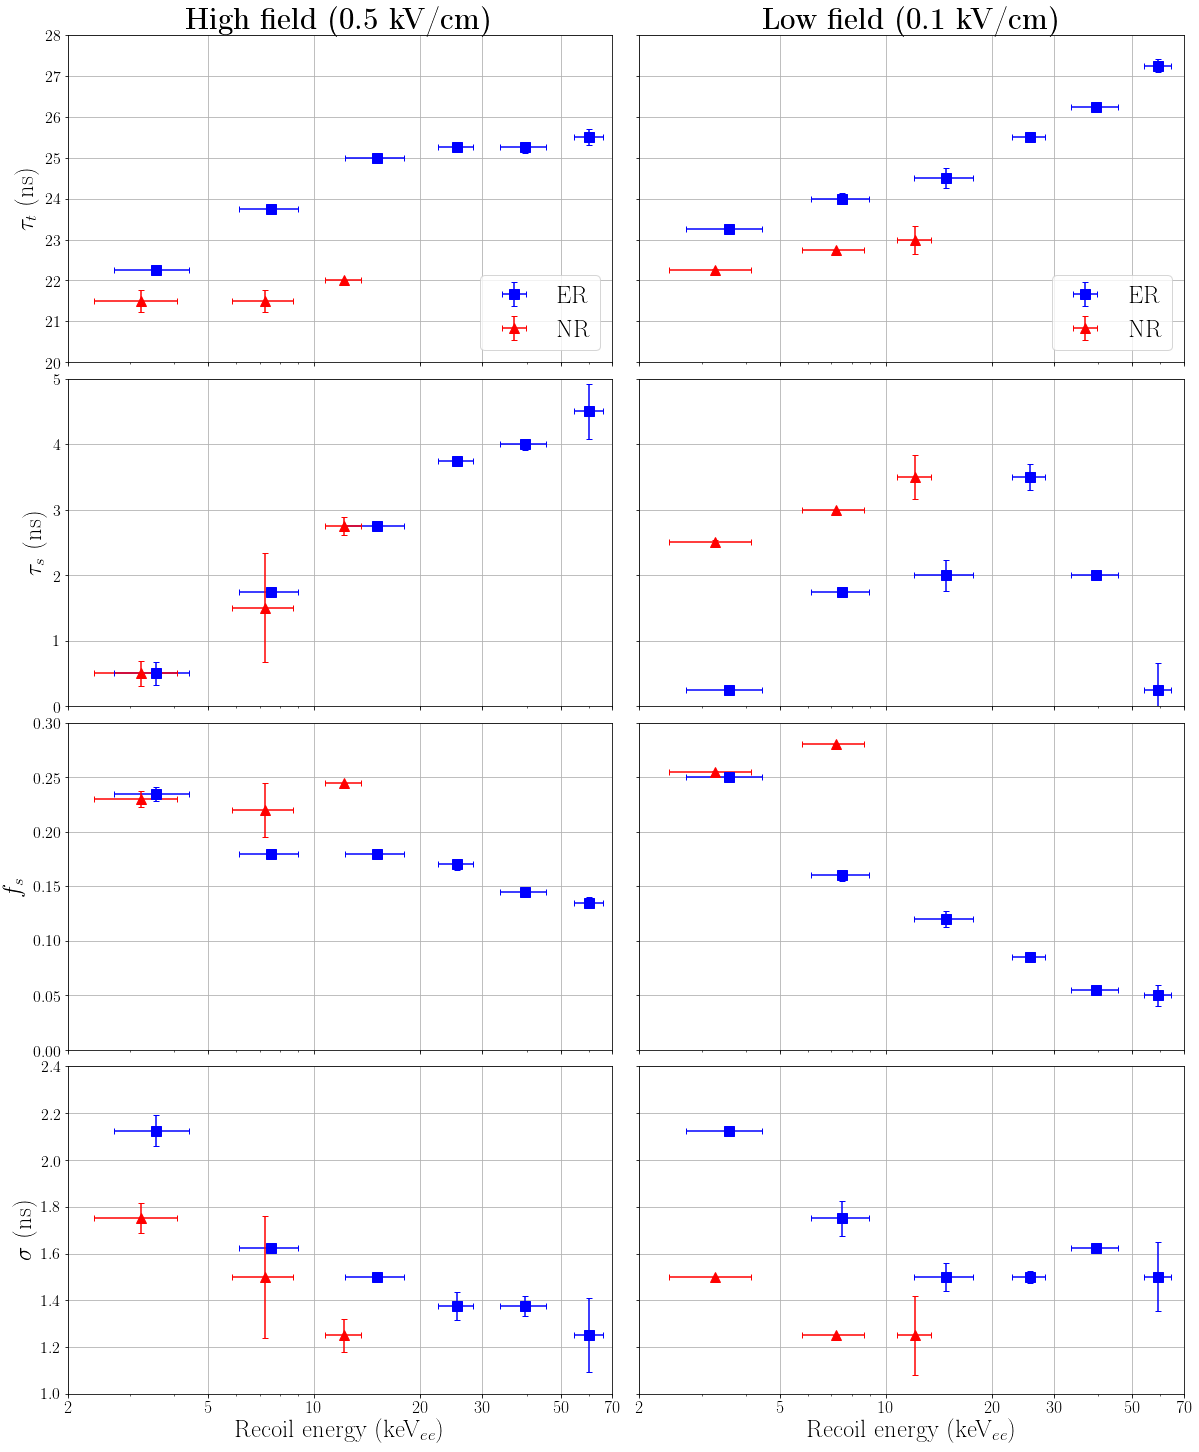

In [35]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

f = plt.figure(figsize=(20,25))
gs = gridspec.GridSpec(4, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# Set grid and x limits
for ax in axes:
    ax.set_xlim(2, 70)
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(xtick) for xtick in xticks])
    ax.grid()
    

for ax in axes:
    if ax == ax6 or ax==ax7:
        continue
    ax.set_xticklabels([])

# Plot titles
ax0.set_title(r'\bf High field (0.5 kV/cm)')
ax1.set_title(r'\bf Low field (0.1 kV/cm)')

# x-axis titles
for ax in [ax6, ax7]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')

# Turn off y-axis ticks for 
for ax in [ax1, ax3, ax5, ax7]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\tau_{t}$ (ns)")
ax2.set_ylabel(r"$\tau_{s}$ (ns)")
ax4.set_ylabel(r'$f_s$')
ax6.set_ylabel(r'$\sigma$ (ns)')

for x, l, c, marker in zip([x_er, x_nr], ['ER', 'NR'], ['blue', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax0, ax2, ax4, ax6]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = x['d' + ypar], 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([x_er_l, x_nr_l], ['ER', 'NR'], ['blue', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax1, ax3, ax5, ax7]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = x['d' + ypar], 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  

for ax in [ax0, ax1]:
    ax.set_ylim(20, 28)
for ax in [ax2, ax3]:
    ax.set_ylim(0, 5)
for ax in [ax4, ax5]:
    # Singlet fraction
    ax.set_ylim(0., 0.30)
for ax in [ax6, ax7]:
    # tts
    ax.set_ylim(1, 2.4)
    
for ax in axes:
#     if ax in [ax0, ax1, ax2, ax7]:
#         ax.legend(loc='lower right')
#     if ax in [ax4, ax6]:
#         ax.legend(loc='lower left')
#     if ax in [ax3]:
#         ax.legend(loc='upper right')
    if ax in [ax0, ax1]:
        ax.legend(loc='lower right')
    
plt.savefig('/home/erik/win/notes/giant_plotfig.pdf', bbox_inches='tight')

## Fit example

This requires the four-fit data to have been read, and the ddf from `Read all four-fit data` 

In [53]:
df = ddf_er[2]

In [155]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [208]:
import matplotlib as mpl
def fancyplot(**params):
    gridalpha = 0.3
    
    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)

    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    plt.sca(ax1)
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[1]._legmarker.set_markersize(8)
    plt.ylim(0, None)
    plt.title(r'\bf{Electronic recoil, %d - %d keV}' % (params['e_min'], params['e_max']))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    
    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
#     plt.xlim(-12, 150)
#     for _l in (params['t_min'], params['t_max']):
#         plt.axvline(_l)
    plt.xlim(params['t_min'], params['t_max'])

    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel("Residual")
    plt.xlabel("Time (ns)")
    plt.gcf().subplots_adjust(0,0,1,1,0,0)
    ax1.get_yaxis().set_label_coords(-0.067 ,0.5)
    # ax2.get_yaxis().set_label_coords(0, 0.5)
    


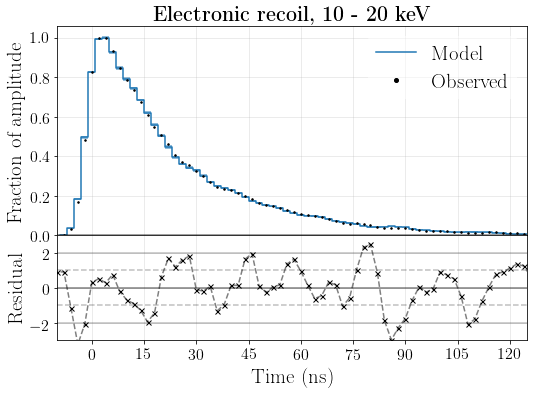

In [209]:
fancyplot(**minvalue(df, to_input=True))
plt.savefig('pulsefit.pdf', bbox_inches='tight')

In [298]:
def fancylong(**params):
    gridalpha = 0.3
    h_bottom = 0.15
    h_top = (0.8 - h_bottom)/2

    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)
    xlim = (params['t_min'], params['t_max'])

    plt.figure(figsize = (6.531496194824962, 2* 4.3543307965499745)) # Double height figure
    
    #### FRAME 1
    frame1=plt.gcf().add_axes((.1,0.1 + h_top + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid', label='Uncertainty')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')
    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame1.get_xticklabels(), visible=False)
    plt.axhline(0, c='k', alpha=0.5)
    handles, labels =  frame1.get_legend_handles_labels()
    labels = [labels[0], labels[2], labels[1]]
    handles = [handles[0], handles[2],handles[1]]
    leg = plt.legend(handles, labels, loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[2]._legmarker.set_markersize(8)
    plt.ylim(0, 1.1)
    plt.title(r'\bf{Electronic recoil, %d - %d keV}' % (params['e_min'], params['e_max']))
    plt.yticks(np.arange(0.2, 1.2, 0.2))

    plt.xlim(xlim)
    #### FRAME 2
    frame2=plt.gcf().add_axes((.1,0.1 + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame2.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    plt.yscale('log')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    plt.xlim(xlim)
    plt.xticks(np.arange(0, 140, 20))
    plt.ylim(5e-4, 1.2)
    frame3=plt.gcf().add_axes((.1,.1,.8, h_bottom))
    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    plt.xlim(xlim)
    plt.yticks([-2, -1, 0, 1, 2])
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel("Residual")
    plt.xlabel("Time (ns)")
    
    frame2.get_yaxis().set_label_coords(-0.10 , 1)
    frame3.get_yaxis().set_label_coords(-0.10 , 0.5)
    print(params['chi2'])

1.56593348767


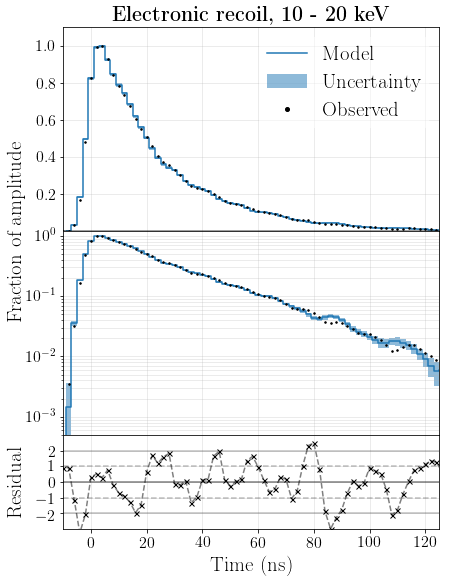

In [299]:
fancylong(**minvalue(df, to_input=True))
# plt.savefig('pulsefit.pdf', bbox_inches='tight')

## Chi2 evolution

In [173]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


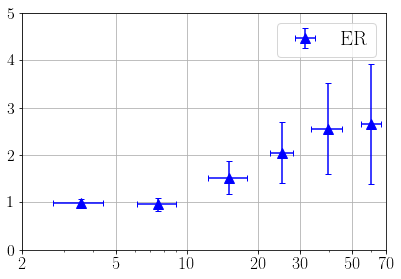

In [180]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

for x, l, c in zip([x_er], ['ER'], ['blue']):
    plt.errorbar(x['e'], x['chi2'], xerr=x['de'], yerr=x['dchi2'],
                 label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)
    
plt.xlim(2, 70)
plt.xscale('log')
plt.xticks(xticks)
plt.gca().set_xticklabels([str(xtick) for xtick in xticks])
plt.grid()
plt.ylim(0, 5)
plt.legend()
plt.show()

# Improvements (R&D section)

## Super fit

In [104]:
df = read_pickles(data_dir, 'er_50_70_recomb2')

Read 30870 datapoints from 61 files.


In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

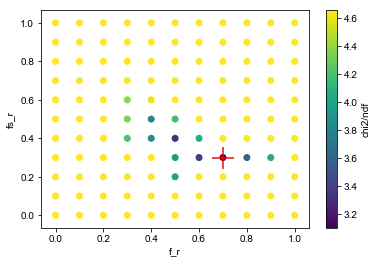

In [109]:
parslice_2d(df1, 'f_r', 'fs_r')

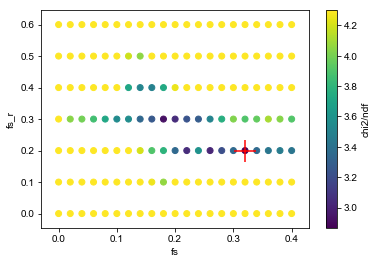

In [111]:
parslice_2d(df, 'fs', 'fs_r')

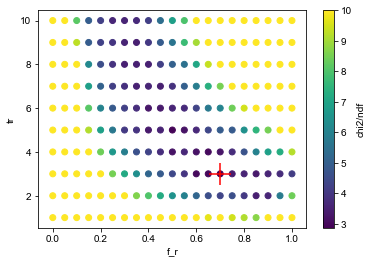

In [117]:
parslice_2d(df, 'f_r', 'tr', vmax=10)

In [123]:
ding = df['chi2'].values

In [126]:
ding = ding[np.invert(np.isnan(ding))]

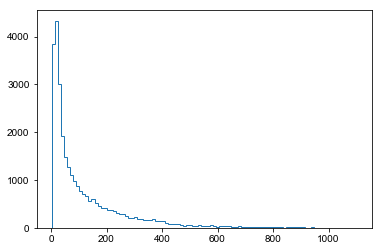

In [128]:
plt.hist(ding, bins=100, histtype='step')
plt.show()

In [115]:
minval

{'chi2': 2.8662572479744401,
 'dset': 'er',
 'e_max': 70,
 'e_min': 50,
 'f_r': 0.70000000000000007,
 'fs': 0.32000000000000001,
 'fs_r': 0.19999999999999998,
 'n_photons': 1000000,
 's1_model': 'recombination',
 'stored_stat': True,
 't1': 2.0,
 't3': 21.5,
 'tr': 3.0,
 'tts': 1.5}

In [93]:
df[(df['f_r'] > 0.699) & (df['f_r'] < 0.701)]

chi2 dset  e_max  e_min  f_r   fs  fs_r  \
9317     73.295811   er     70     50  0.7  0.0   0.0   
9318    190.227476   er     70     50  0.7  0.0   0.0   
9319    323.495981   er     70     50  0.7  0.0   0.0   
9320    450.228278   er     70     50  0.7  0.0   0.0   
9321    573.799714   er     70     50  0.7  0.0   0.0   
9322    633.741691   er     70     50  0.7  0.0   0.0   
9323    730.944182   er     70     50  0.7  0.0   0.0   
9324    912.153393   er     70     50  0.7  0.0   0.0   
9325   1078.858943   er     70     50  0.7  0.0   0.0   
9326   1201.830949   er     70     50  0.7  0.0   0.0   
9327   1137.422435   er     70     50  0.7  0.0   0.0   
9328     26.506463   er     70     50  0.7  0.0   0.1   
9329    103.092110   er     70     50  0.7  0.0   0.1   
9330    215.120488   er     70     50  0.7  0.0   0.1   
9331    320.741142   er     70     50  0.7  0.0   0.1   
9332    448.436815   er     70     50  0.7  0.0   0.1   
9333    493.016719   er     70     50  0.7  0.0   0.1   
9334    637.407848   er     70     50  0.7  0.0   0.1   
9335    716.142114   er     70     50  0.7  0.0   0.1   
9336    864.984173   er     70     50  0.7  0.0   0.1   
9337    917.821512   er     70     50  0.7  0.0   0.1   
9338   1060.122635   er     70     50  0.7  0.0   0.1   
9339      8.220013   er     70     50  0.7  0.0   0.2   
9340     41.720903   er     70     50  0.7  0.0   0.2   
9341    122.497684   er     70     50  0.7  0.0   0.2   
9342    199.870478   er     70     50  0.7  0.0   0.2   
9343    305.598089   er     70     50  0.7  0.0   0.2   
9344    373.924315   er     70     50  0.7  0.0   0.2   
9345    496.880945   er     70     50  0.7  0.0   0.2   
9346    546.266038   er     70     50  0.7  0.0   0.2   
...            ...  ...    ...    ...  ...  ...   ...   
36661   267.436774   er     70     50  0.7  0.4   0.4   
36662   151.881290   er     70     50  0.7  0.4   0.4   
36663    97.235982   er     70     50  0.7  0.4   0.4   
36664    47.395613   er     70     50  0.7  0.4   0.4   
36665    27.436544   er     70     50  0.7  0.4   0.4   
36666    15.108295   er     70     50  0.7  0.4   0.4   
36667    12.689646   er     70     50  0.7  0.4   0.4   
36668    18.899714   er     70     50  0.7  0.4   0.4   
36669    30.920112   er     70     50  0.7  0.4   0.4   
36670    43.097391   er     70     50  0.7  0.4   0.4   
36671   391.262496   er     70     50  0.7  0.4   0.5   
36672   277.232412   er     70     50  0.7  0.4   0.5   
36673   163.212018   er     70     50  0.7  0.4   0.5   
36674   114.551627   er     70     50  0.7  0.4   0.5   
36675    70.391358   er     70     50  0.7  0.4   0.5   
36676    45.505597   er     70     50  0.7  0.4   0.5   
36677    28.660367   er     70     50  0.7  0.4   0.5   
36678    19.445382   er     70     50  0.7  0.4   0.5   
36679    18.475781   er     70     50  0.7  0.4   0.5   
36680    23.615597   er     70     50  0.7  0.4   0.5   
36681   581.584368   er     70     50  0.7  0.4   0.6   
36682   420.739713   er     70     50  0.7  0.4   0.6   
36683   297.383805   er     70     50  0.7  0.4   0.6   
36684   214.342039   er     70     50  0.7  0.4   0.6   
36685   145.693243   er     70     50  0.7  0.4   0.6   
36686   104.503742   er     70     50  0.7  0.4   0.6   
36687    68.926069   er     70     50  0.7  0.4   0.6   
36688    46.923212   er     70     50  0.7  0.4   0.6   
36689    33.572238   er     70     50  0.7  0.4   0.6   
36690    25.795648   er     70     50  0.7  0.4   0.6   

                                                   model  n_photons  \
9317   [5.04278836172e-05, 6.64480166456e-05, 7.62985...    1000000   
9318   [4.86000717604e-05, 6.08964960707e-05, 6.96333...    1000000   
9319   [4.6985911913e-05, 5.75278593635e-05, 6.565069...    1000000   
9320   [4.60073643529e-05, 5.52492932017e-05, 6.27590...    1000000   
9321   [4.49722116678e-05, 5.34703057203e-05, 6.04372...    1000000   
9322   [4.44929977429e-05, 5.23919242437e-05, 5.88562

In [130]:
p0 = {}

In [131]:
default_params['stored_stat_value'] = real_s1_wv_sigma(**p0)

In [139]:
%%time
gof(n_photons=int(1e6))

gof=4.8246944968905465, fs=0.2, t1=3.1, t3=24, tts=2.0
CPU times: user 15.1 s, sys: 3.83 s, total: 18.9 s
Wall time: 8.02 s


4.8246944968905465

## Interpretation of chi2 thing

In [450]:
ndf = 20
offset = 2.5
sigma = 2

def get_chi2(ndf, sigma, f_real, preal, f_fit, x0, xreal, plot=False, ret = 'ratio'):    
    t       = np.linspace(0, 100, ndf)
    err_est = np.ones(ndf) * sigma
    y = f_real(t, **preal)
    dy = np.random.normal(loc=0, scale=sigma, size=ndf)
    y = y + dy
    
    if plot:
        plt.plot(t, y)
    truefit = np.sum(((y - f_fit(t, xreal)) / err_est)**2) / ndf
    if ret == 'truevalue':
        return truefit
    
    optres = scipy.optimize.minimize(lambda x : np.sum(((y - f_fit(t, x)) / err_est)**2) / ndf, x0).fun
    return truefit / optres


In [387]:
(126 + 2) /2

64.0

In [388]:
def const(x, a):
    return a

In [413]:
get_chi2(64, 1, const, {'a':1}, const, 2)

2.2002291566520271

In [435]:
chi2s = [get_chi2(64, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.015860


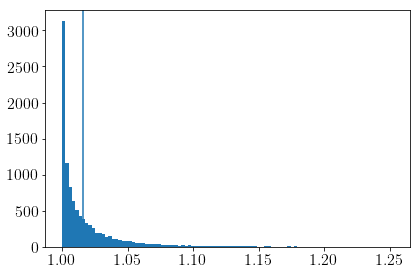

In [436]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [454]:
chi2s = [get_chi2(6, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.241256


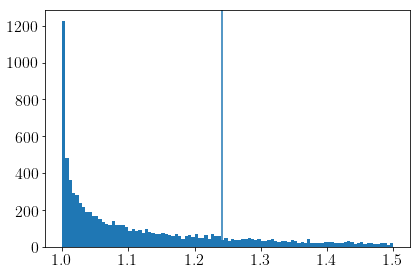

In [456]:
plt.hist(chi2s, bins=100, range=(1, 1.5))
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [422]:
def const_w_osc(x, a, period, amp):
    return a + amp * np.cos(2 * np.pi * x/period)

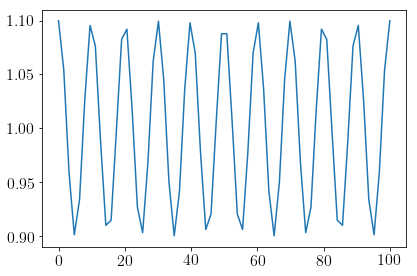

In [423]:
t = np.linspace(0, 100, 64)
plt.plot(t, const_w_osc(t, 1, 10, 0.1))

1.0000372882850095

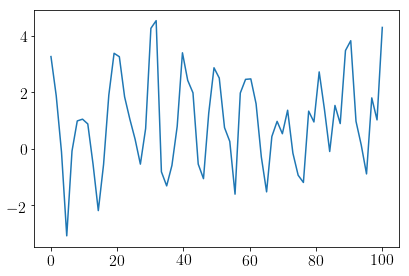

In [443]:
get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, plot=True)

In [437]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=0.1), const, 2, 1) for _ in range(10000)]

Cutoff at 1.015604


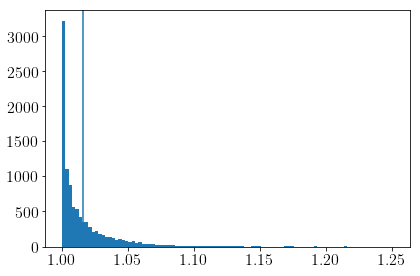

In [438]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [457]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=1.), const, 2, 1) for _ in range(10000)]

Cutoff at 1.010703


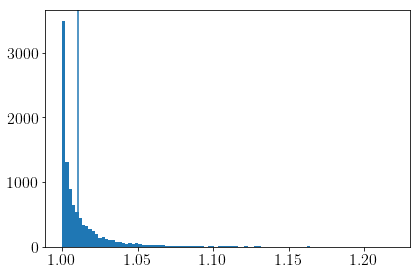

In [458]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [444]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1) for _ in range(10000)]

Cutoff at 1.005576


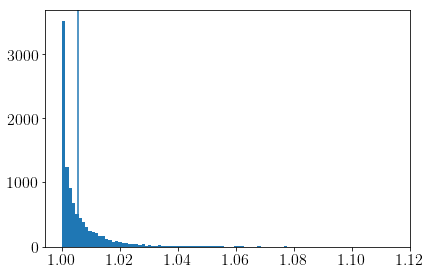

In [445]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [451]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, ret='truevalue') for _ in range(10000)]

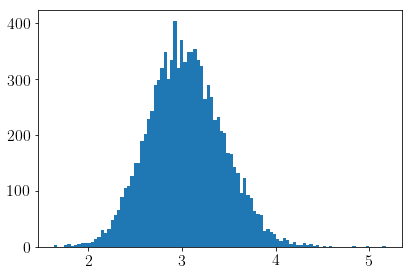

In [453]:
plt.hist(chi2s, bins=100)
plt.show()

## Data-driven spe error

In [61]:
df = read_pickles(data_dir, 'er_e_10_20_newer_spe')

Read 5103 datapoints from 25 files.


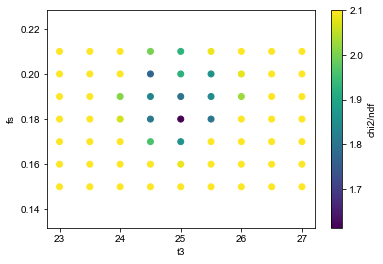

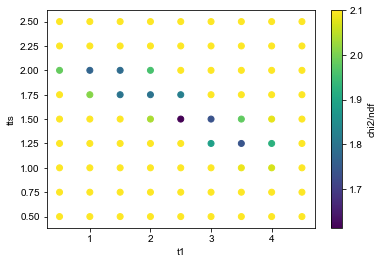

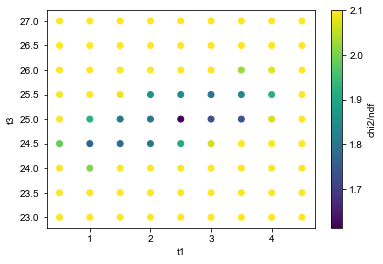

In [62]:
plot_all_slices(df, vmax=2.1)

In [63]:
minvalue(df)

{'chi2': 1.6126650051442681,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.17999999999999999,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 2.5,
 't3': 25.0,
 'tts': 1.5}

In [67]:
popt = minvalue(df, to_input=True)

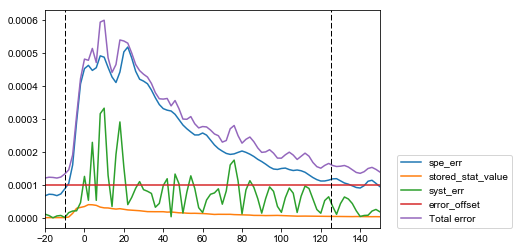

Chi2 in peak: (-10 to 30 ns): 1.93
Chi2 in tail: (30 to 125 ns): 1.48
Chi2 total: 1.61


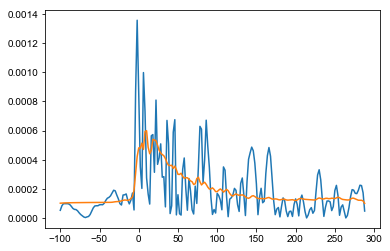

In [68]:
check_errors(**popt)

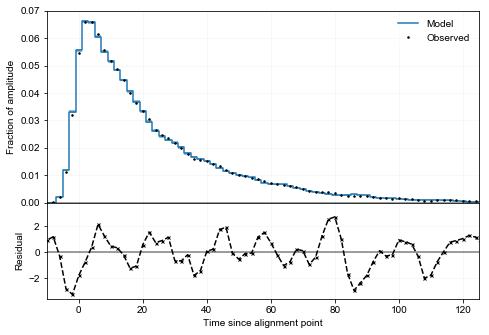

chi2 = 1.612665


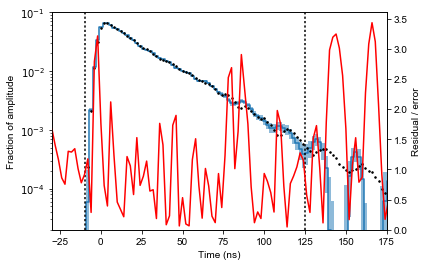

In [69]:
plot_model_manual(**popt)

In [80]:
mins = get_some_minima(df, 100, threshold=popt['chi2'] + 0.25)

Selected 15 values with chi2 ranging from 1.61 to 1.86...


In [81]:
print_minima(mins)

Giving the standard deviation for 15 points...
fs = 0.187 +- 0.009
t3 = 25.000 +- 0.365
t1 = 2.333 +- 0.745
tts = 1.650 +- 0.220
Giving the MAXIMUM deviation from BEST-FIT POINT (using chi2) for 15 points...
fs = 0.180 + 0.010 - 0.020
t3 = 25.000 + 0.500 - 0.500
t1 = 2.500 + 1.500 - 1.000
tts = 1.500 + 0.250 - 0.500


## Quad errors

In [124]:
p

{'chi2': 0.15445825612565142,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.19,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 1.5,
 't3': 24.5,
 'tts': 1.75}

In [125]:
model, sigma_syst, spe_err = s1_models_error(**p)

In [128]:
p['stored_stat_value'] = real_s1_wv_sigma(**p)

In [129]:
default_params['stored_stat_value'] = p['stored_stat_value']

In [130]:
# Build dicts
p = deepcopy(minvalue(df))
p1 = deepcopy(p)
p2 = deepcopy(p)

# Extract these parameters only once
# default_params['stored_stat_value'] = real_s1_wv_sigma(**p)
ydata, _ = real_s1_wv(**p)

# Now for p1...
p1['quad_adding'] = False
model, sigma_syst, spe_err = s1_models_error(**p1)
p1['ydata'], p1['model'], p1['syst_err'], p1['spe_err'] = (ydata, model, syst_err, spe_err)
p1['chi2'] = gof_manual(**p1)

# Now for p2...
p2['quad_adding'] = True
model, sigma_syst, spe_err = s1_models_error(**p2)
p2['ydata'], p2['model'], p2['syst_err'], p2['spe_err'] = (ydata, model, syst_err, spe_err)
p2['chi2'] = gof_manual(**p2)


gof=0.09465571363944048, fs=0.19, t1=1.5, t3=24.5, tts=1.75
gof=1.7652950812151533, fs=0.19, t1=1.5, t3=24.5, tts=1.75


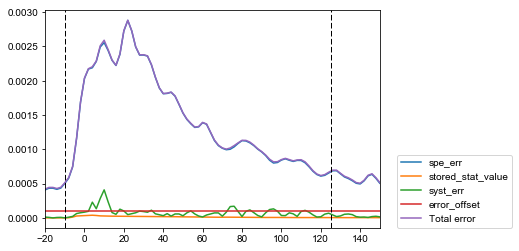

Chi2 in peak: (-10 to 30 ns): 0.13
Chi2 in tail: (30 to 125 ns): 0.08
Chi2 total: 0.09


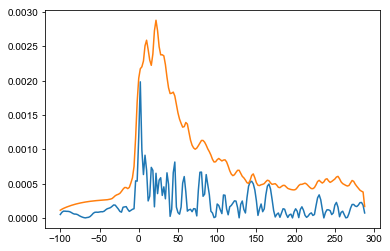

In [137]:
check_errors(**p1)

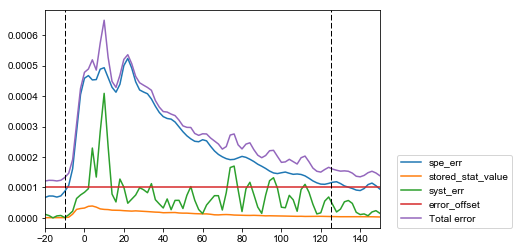

Chi2 in peak: (-10 to 30 ns): 1.90
Chi2 in tail: (30 to 125 ns): 1.71
Chi2 total: 1.77


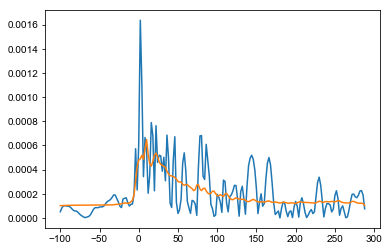

In [138]:
check_errors(**p2)

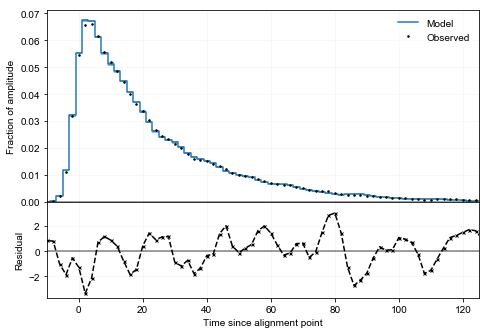

chi2 = 1.765295


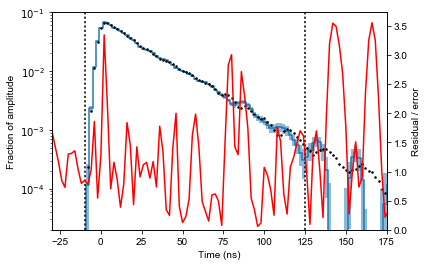

In [140]:
plot_model_manual(**p2)

In [ ]:
p1 = deepcopyy(p)

In [126]:
chi2 = gof_manual(ydata, model, syst_err, spe_err, **p)

array([  5.20008159e-05,   8.47355915e-05,   1.02297844e-04,
         1.01559138e-04,   9.87126241e-05,   9.81849245e-05,
         9.37794639e-05,   8.21374492e-05,   6.78890058e-05,
         6.17913444e-05,   6.12944478e-05,   5.41079202e-05,
         4.03611282e-05,   2.76511637e-05,   1.85283561e-05,
         9.43267479e-06,  -2.71787493e-07,  -3.95600837e-06,
        -3.84434292e-06,  -1.25557692e-05,  -3.69324599e-05,
        -6.39809951e-05,  -7.80271292e-05,  -7.77174749e-05,
        -7.68658021e-05,  -8.45702340e-05,  -8.96419877e-05,
        -8.99425294e-05,  -9.82332813e-05,  -1.14727921e-04,
        -1.29448630e-04,  -1.38047585e-04,  -1.47496811e-04,
        -1.65889237e-04,  -1.86150812e-04,  -1.85635908e-04,
        -1.57807243e-04,  -1.28605697e-04,  -1.26729894e-04,
        -1.58870012e-04,  -1.99186883e-04,  -2.19175853e-04,
        -2.14603853e-04,  -1.82281583e-04,  -1.42351299e-04,
        -1.25709451e-04,   9.84058905e-05,   2.29536223e-03,
         1.17664296e-02,

## Shift per s1

In [220]:
s1_waveforms, s1_waveforms_error, time_matrix, t_shift = simulate_s1_pulse(n_photons = int(1e6), max_shift = 10)

(-10, 20)

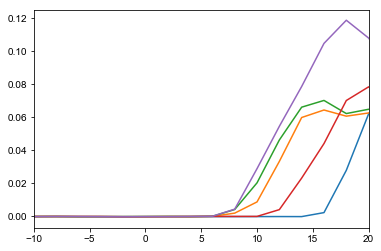

In [214]:
for i in range(5):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

(-10, 20)

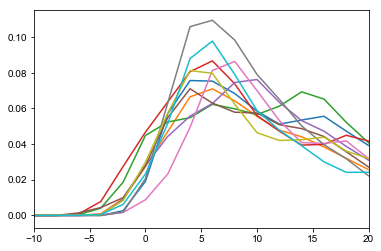

In [221]:
for i in range(10):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

(-10, 20)

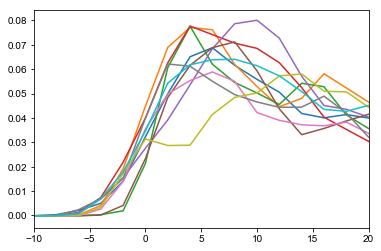

In [219]:
for i in range(10):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

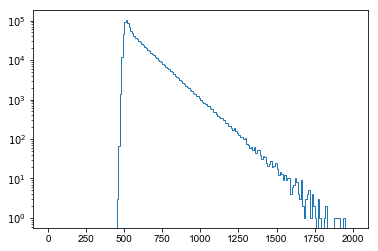

In [197]:
plt.hist(bla, range=(0, 2000), histtype='step', bins=200)
plt.yscale('log')
plt.show()

In [230]:
p = deepcopy(minvalue(df, to_input=False, keep_only_stored=True))

{'s1_model': 'two_exp', 'e_min': 10, 'tr': 15, 'neglect_statistical': False, 'max_shift': 10, 'dset': 'er', 'aft': 0.28, 'f_r': 0.0, 't3': 25.0, 'fs': 0.17999999999999999, 'tts': 1.5, 'e_max': 20, 'n_photons': 500000, 'error_offset': 0.0001, 't_max': 125.0, 't_min': -10.0, 't1': 2.5, 'quad_adding': True, 'stored_stat_value': array([  3.07804535e-08,   5.92180795e-08,   7.09834496e-08,
         5.14710958e-08,   3.01168574e-08,   4.08173680e-08,
         3.73462117e-08,   3.32615231e-08,   7.52955756e-08,
         1.15710767e-07,   1.19748888e-07,   1.34387793e-07,
         1.35912606e-07,   1.62253800e-07,   1.85788174e-07,
         1.86828163e-07,   2.14834888e-07,   1.93726183e-07,
         1.94519866e-07,   2.01598222e-07,   1.80019982e-07,
         1.71336610e-07,   1.78384911e-07,   1.94799460e-07,
         2.41142740e-07,   2.43048638e-07,   2.24170074e-07,
         1.95812491e-07,   2.10763441e-07,   2.28679693e-07,
         2.33560324e-07,   2.06717925e-07,   1.95629026e-07,
  

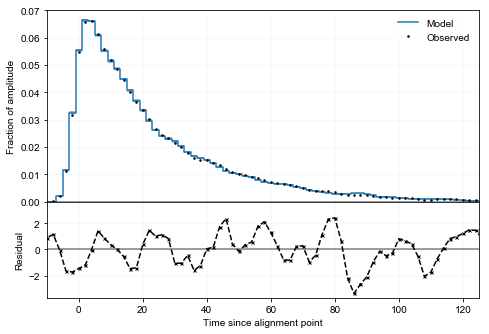

chi2 = 1.607674


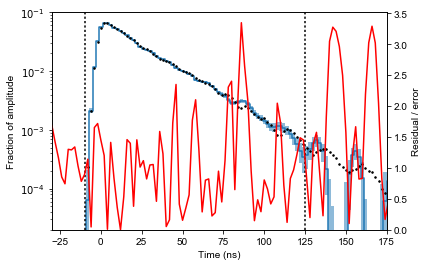

In [232]:
plot_model(**p)

## Sub-sample alignment

This has been implemented, done now.

## Statistics...

This part may be outdated after the error redefinition

In [73]:
gofs_list = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=4.847686336182956, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.893724830132279, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.6621421313708025, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.960056160807073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.036084011427087, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.435783839662097, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.426565338782284, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.506808589426186, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.377088315327442, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!


In [88]:
nph_scan = [int(2e5), int(4e5), int(2e6), int(4e6)]

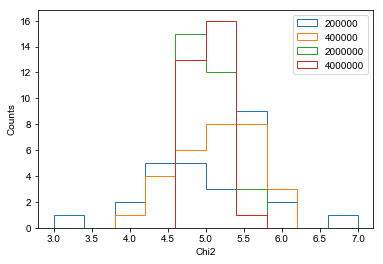

In [89]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(gofs, histtype = 'step', bins=10, range=(3,7), label='%d' % l)
plt.xlabel('Chi2')
plt.ylabel('Counts')
plt.legend()
plt.show()

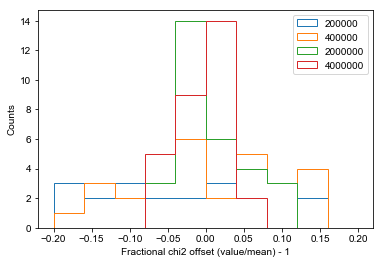

In [90]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(np.array(gofs) / np.mean(gofs) - 1, histtype = 'step', bins=10, range=(-.2,.2), label='%d' % l)
plt.xlabel('Fractional chi2 offset (value/mean) - 1')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [91]:
np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1)

array([ 0.18106677,  0.10032424,  0.04895351,  0.0351447 ])

In [92]:
gofs_list_stat = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
popt['neglect_systematic'] = False
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list_stat.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=2.994595859402191, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.7180867413599614, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.581299280602138, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3044093119377864, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=3.87797057226319, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3584730945375254, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.9466589522782445, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.2913916890875003, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.8378287717356594, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat paramet

In [94]:
np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1)

array([ 0.26617473,  0.19006954,  0.06307608])

#### The money plot

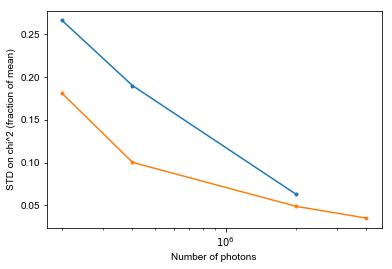

In [125]:
plt.plot(nph_scan, np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1), marker='.')
plt.plot(np.concatenate([nph_scan, [int(4e6)]]), np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1), marker='.')
plt.xscale('log')
plt.xlabel('Number of photons')
plt.ylabel('STD on chi^2 (fraction of mean)')

### Number of bootstrap trials

In [129]:
popt['n_photons'] = int(1e6)
popt['stored_stat'] = False

boot_scan = [20, 100, 200, 1000]
boots = []
for bt in boot_scan:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])


20
gof=1.934865562922848, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.294249914987514, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.897927975499547, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.20651953781785, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3404212287590673, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.824898948772344, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8283130743557883, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.452338891592939, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0894702055698833, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.5820449784985073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.9172095355070393, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.789504337155653, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4301882420563343, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.544293321063236, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.240761883540313, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4581112505576193, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3309261638355525, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=

KeyboardInterrupt: 

In [135]:
for bt in [400]:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])

400
gof=2.169790799650517, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0958783567618977, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0437041529418414, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.189776783448054, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.335455337573744, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.016523940034678, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.957150616151253, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2426380687513316, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0268897915146216, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7702937134946244, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2007160689622935, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8613155479428471, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.138296685063111, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0494810091269486, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7838359820359413, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.880781820935462, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.299482036700427, fs=0.19, t1=2.0, t3=25.0, tts=1.75
g

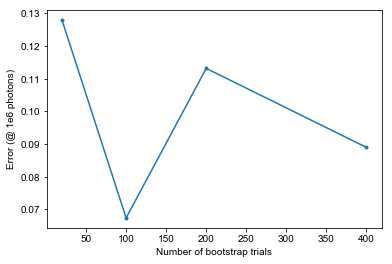

In [136]:
plt.plot([20, 100, 200, 400], np.std(boots, axis=1) / np.mean(boots, axis=1), marker='.')
plt.xlabel('Number of bootstrap trials')
plt.ylabel('Error (@ 1e6 photons)')

It looks like at 1M photons, the number of bootstrap trials is not so important as long as it is high enough (>= 100)